# Udacity + Arvato Financial Solutions: Identify Customers from a Mailout Campaign

In the project, a mail-order sales company in Germany is interested in identifying segments of the general population to target with their marketing in order to grow. Demographics information has been provided for both the general population at large as well as for prior customers of the mail-order company in order to build a model of the customer base of the company. **The target dataset contains demographics information for targets of a mailout marketing campaign.** The objective is **to identify which individuals are most likely to respond to the campaign and become customers of the mail-order company**.

As part of the project, half of the mailout data has been provided with included response column. For the competition, the remaining half of the mailout data has had its response column withheld; the competition will be scored based on the predictions on that half of the data.

## Work in this notebook
**High-level summary:** 
1. In the unsupervised problem, KMeans Clustering is used to achieve the customer segmentation. More specifically, PCA will be used to reduce the dimensions of the raw features and extract most useful features (i.e., principle components). 
2. The PCA transformer learned from the unsupervised problem will play as a key feature engineering approach for the supervised problem. 
3. In the supervised problem, various machine learning algorithms (e.g., Random Forest, XGBoost, Logistic Regression) have been employed to solve the classification problem. 
4. Necessary visualizations are performed for better exploring the problem, and typical machine learning training practices are conducted, for example, cross-validation/early stopping for hyperparameter tuning.

## Part 1. Unsupervised problem:
**DataSet 1:** demographics data for customers of a mail-order sales company in Germany. <br>
name: Udacity_CUSTOMERS_052018.csv <br>
size: (191652, 369) <br>

**DataSet 2:** demographics information for the general population name: Udacity_AZDIAS_052018.csv <br>
Size: (891211, 366) <br>
## Part 2. Supervised problem:
**DataSet 3 (Training set):** demographics data for individuals who were targets of a marketing campaign; <br>
name: Udacity_MAILOUT_052018_TRAIN.csv, <br>
(42982, 367) <br>

**Data Set 4 (Test set):** demographics data for individuals who were targets of a marketing campaign <br>
name: Udacity_MAILOUT_052018_TEST.csv <br>
size: (42833, 366)<br>

**Note:** there are three extra columns in **DataSet 1**; and **DataSet 3** in supervised problem has a "RESPONSE" column.

<a id="table"><br>
### [Table]:  
#### [Part 0: explore the data](#part-0) 
#### [Part 1: PCA and KMeans clustering](#part-1) 
##### [Part 1.1: PCA: PCA1](#part-1.1) 
##### [Part 1.2: revisit PCA: PCA2](#part-1.2) 
#### [Part 2: Supervised learning](#part-2)
##### [Part 2.1: data preprocess](#part-2-step1)
##### [Legacy: modelling using PCA1](#part-2-PCA1)
##### [Part 2.2: Apply PCA and train a classifier](#part-2-step2)
    2.2.1 apply new PCA
    2.2.2  XGB
    2.2.3. XGB with calibration
    2.2.4. Another random forest
    2.2.5. Logistic regression
    2.2.6. Other attempts    
#### [Part 3: Kaggle competition](#part-3)
</a></br>

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

In [2]:
# lcx:
import gc

In [3]:
import sys
print(sys.version)
print(sys.path)

3.6.3 | packaged by conda-forge | (default, Dec  9 2017, 04:28:46) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
['', '/opt/spark-2.4.3-bin-hadoop2.7/python', '/opt/spark-2.4.3-bin-hadoop2.7/python/lib/py4j-0.10.7-src.zip', '/home/workspace', '/opt/conda/lib/python36.zip', '/opt/conda/lib/python3.6', '/opt/conda/lib/python3.6/lib-dynload', '/opt/conda/lib/python3.6/site-packages', '/opt/conda/lib/python3.6/site-packages/Mako-1.0.7-py3.6.egg', '/opt/conda/lib/python3.6/site-packages/cycler-0.10.0-py3.6.egg', '/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg', '/opt/conda/lib/python3.6/site-packages/IPython/extensions', '/root/.ipython']


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
# import some helper functions
sys.path.insert(0, "./helper_functions/")

<a id="part-0"><br>
    
## Part 0: Get to Know the Data
</a></br> Go to [Table](#table)<br>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. **Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.**

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In [6]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

### Check the missing data, column-wise and row-wise

In [24]:
def miss_data_check_col(df):
    # pandas.core.series.Series
    col_nan = df.isnull().sum()/df.shape[0]
    print('Columns with null values:' )
    #print('\n'.join('{:6.2f}'.format(val) for val in col_nan.values))
    print("-"*10)
    print('Columns null values histogram:\n')
    fig, ax = plt.subplots(figsize=(8,6))
    ax = col_nan.hist(bins=np.arange(11)*0.1)
    ax.set_xlabel("Missing value percentage")
    ax.set_ylabel("Numbers of columns")
    return col_nan

Columns with null values:
----------
Columns null values histogram:



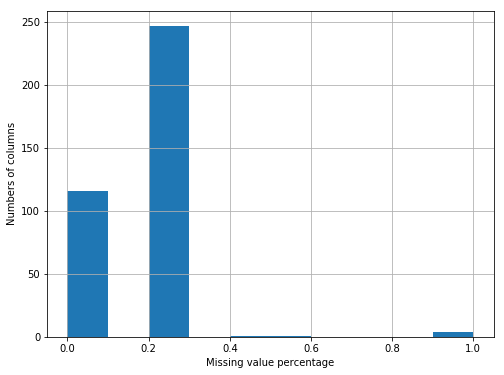

In [25]:
col_nan = miss_data_check_col(customers)
plt.savefig("missing_value_column_wise.pdf")

In [23]:
col_nan[col_nan > 0.6]

ALTER_KIND1    0.938607
ALTER_KIND2    0.973389
ALTER_KIND3    0.993347
ALTER_KIND4    0.998769
dtype: float64

In [27]:
col_nan[col_nan > 0.4]

ALTER_KIND1     0.938607
ALTER_KIND2     0.973389
ALTER_KIND3     0.993347
ALTER_KIND4     0.998769
EXTSEL992       0.444989
KK_KUNDENTYP    0.584064
dtype: float64

In [36]:
col_nan.sort_values(ascending=False)

ALTER_KIND4                  0.998769
ALTER_KIND3                  0.993347
ALTER_KIND2                  0.973389
ALTER_KIND1                  0.938607
KK_KUNDENTYP                 0.584064
EXTSEL992                    0.444989
KBA05_SEG7                   0.292092
KBA05_KW1                    0.292092
KBA05_SEG4                   0.292092
KBA05_SEG5                   0.292092
KBA05_SEG6                   0.292092
KBA05_MAXAH                  0.292092
KBA05_SEG8                   0.292092
KBA05_KW2                    0.292092
KBA05_VORB0                  0.292092
KBA05_KRSZUL                 0.292092
KBA05_VORB1                  0.292092
KBA05_KRSVAN                 0.292092
KBA05_KRSOBER                0.292092
KBA05_SEG9                   0.292092
MOBI_REGIO                   0.292092
KBA05_KW3                    0.292092
KBA05_SEG3                   0.292092
KBA05_KRSHERST3              0.292092
KBA05_MAXBJ                  0.292092
KBA05_MAXHERST               0.292092
KBA05_MAXSEG

In [40]:
# define a function to search the columns whose names include the keyword
def print_col_contain_keyword(keyword, col_all):
    #for col_name in customers.columns.tolist():
    for col_name in col_all:
        if keyword in col_name:
            print(col_name)

print_col_contain_keyword("DIGIT_SERV", customers.columns.tolist())

#### the type "object" (str) should also be taken care of
* why they are "object(str)" type;
* how should we transform them so they can be fed to the algorithm.

In [45]:
col_types = customers.dtypes

col_types[col_types == object]

CAMEO_DEU_2015              object
CAMEO_DEUG_2015             object
CAMEO_INTL_2015             object
D19_LETZTER_KAUF_BRANCHE    object
EINGEFUEGT_AM               object
OST_WEST_KZ                 object
PRODUCT_GROUP               object
CUSTOMER_GROUP              object
dtype: object

In [47]:
col_obj_type = col_types[col_types == object].index.tolist()
customers[col_obj_type].head(4)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ,PRODUCT_GROUP,CUSTOMER_GROUP
0,1A,1,13,D19_UNBEKANNT,1992-02-12 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
1,NaN,NaN,NaN,D19_BANKEN_GROSS,NaN,NaN,FOOD,SINGLE_BUYER
2,5D,5,34,D19_UNBEKANNT,1992-02-10 00:00:00,W,COSMETIC_AND_FOOD,MULTI_BUYER
3,4C,4,24,D19_NAHRUNGSERGAENZUNG,1992-02-10 00:00:00,W,COSMETIC,MULTI_BUYER


In [50]:
# this group may be useful, but need to fix the data

# this one may be difficult to deal with? one-hot-encoding? or maybe just delete?
print(customers["CAMEO_DEU_2015"].unique())

# For this, fix the nan and x. And they can be numerical values, no need to one-hot-encoding
print(customers["CAMEO_DEUG_2015"].unique())

# For this, fix the nan and x. And they can be numerical values, no need to one-hot-encoding
print(customers["CAMEO_INTL_2015"].unique())

['1A' nan '5D' '4C' '7B' '3B' '1D' '9E' '2D' '4A' '6B' '9D' '8B' '5C' '9C'
 '4E' '6C' '8C' '8A' '5B' '9B' '3D' '2A' '3C' '5F' '7A' '1E' '2C' '7C' '5A'
 '2B' '6D' '7E' '5E' '6E' '3A' '9A' '4B' '1C' '1B' '6A' '8D' '7D' '6F' '4D'
 'XX']
[1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0 '6' '3' '8' '9' '2' '4' '1' '7'
 '5' 'X']
[13.0 nan 34.0 24.0 41.0 23.0 15.0 55.0 14.0 22.0 43.0 51.0 33.0 25.0 44.0
 54.0 32.0 12.0 35.0 31.0 45.0 52.0 '45' '25' '55' '51' '14' '54' '43' '22'
 '15' '24' '35' '23' '12' '44' '41' '52' '31' '13' '34' '32' '33' 'XX']


In [35]:
customers["KK_KUNDENTYP"].unique()

# should we impute the missing value? If we will use xgboost, this should not be a problem

# According to the DIAS excel, unkown values will be -1

array([ nan,   2.,   5.,   4.,   1.,   3.,   6.])

In [6]:
# histogram of a selected column

def col_hist_plot(df, col_name, **kw):
    
    #ax=plt.subplots(figsize=(6,3))
    print("unique valus in colmn: ", customers["KK_KUNDENTYP"].unique())
    
    # get data by column_name and display a histogram
    if "bins" in kw:
        df[col_name].hist(bins = bins)
    else:
        df[col_name].hist()
        
    title="Histogram of " + col_name
    plt.title(title, fontsize=12)
    plt.show()

unique valus in colmn:  [ nan   2.   5.   4.   1.   3.   6.]


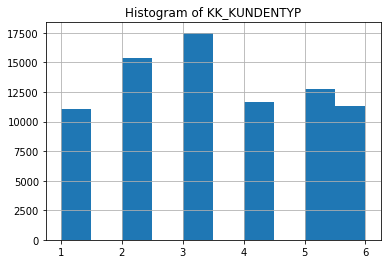

In [7]:
col_hist_plot(customers, 'KK_KUNDENTYP')

In [26]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


In [28]:
customers.shape

(191652, 369)

#### check Row with too many missing value

In [22]:
def miss_data_check_row(df):
    # all a column to indicate the number of missing values
    df["missing_value"] = df.isnull().sum(axis=1)/df.shape[1]
    
    #print('row with null values:' )
    #print('\n'.join('{:6.2f}'.format(val) for val in col_nan.values))
    print("-"*10)
    print('Row null values histogram:\n')
    fig, ax = plt.subplots(figsize=(8,6))
    df["missing_value"].hist(bins=np.arange(11)*0.1, ax=ax)
    ax.set_xlabel("Missing value percentage")
    ax.set_ylabel("Numbers of rows")
    df.drop(columns = ["missing_value"], axis=1, inplace=True)

----------
Row null values histogram:



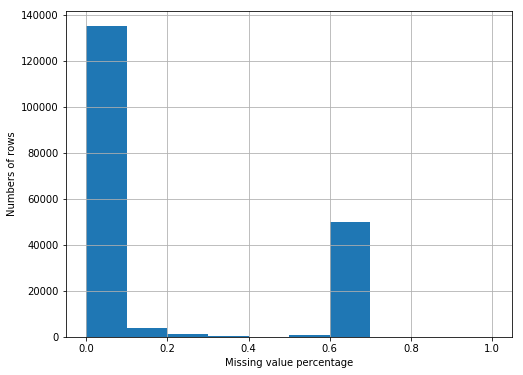

In [23]:
miss_data_check_row(customers)
plt.savefig("missing_value_row_wise.pdf")

In [31]:
# get the number of rows that have more than 60% missing vaule
# 60% is not a very reasonable threshold as too many 
customers[customers["missing_value"] >= 0.6].shape

# need to drop the "missing_value" column later

(49911, 370)

### Note: 

* __missing value, column-wise__

  1. Delete four columns that have more tha 90% missing values;

  2. Delete EXTSEL992. This may be or may not be useful. The DIAS excel does not contain this variable;

  3. Keep KK_KUNDENTYP, becaue "D19_KK_KUNDENTYP" means "consumption movement in the last 12 months". Guess it should be some useful information
  

* __for columns as type "object" (numerical value mixed with string value)__

  1. "D19_LETZTER_KAUF_BRANCHE" "EINGEFUEGT_AM" "OST_WEST_KZ" seems unuseful, may be just delete.
  2. Fix "CAMEO_DEUG_2015" and "CAMEO_INTL_2015".
  3. Hard to deal with "CAMEO_DEU_2015" (if the oder of the values doesn't have the meaning then need to have one-hot-encoding, could create too many columns)<br>
 **Note:** "CAMEO_xxx" are variables representing a set of consumer classifications. <br>
  

* __missing value, row-wise__

  1. Delete those rows with more than 80% missing value 

**All the pre-processing functions can be found in "helper_function/preprocessing.py"**

In [8]:
def drop_columns(df, cols_to_drop):
    #cols_to_drop = list(map(lambda x: "ALTER_KIND"+str(x), [1,2,3,4])) + ["EXTSEL992", "CAMEO_DEU_2015"]
    return df.drop(columns = cols_to_drop, axis=1)
    
def remove_row(df):
    df["missing_value"] = df.isnull().sum(axis=1)/df.shape[1]
    # use 0.6 as threshold before, maybe too much information is lost
    df = df[df["missing_value"] < 0.8]
    return df.drop(columns = ["missing_value"], axis=1)

def miss_data_impu(df):
    # impute the missing value with -1, 
    # according to the data attribute table, this should be a reasonable starting approach
    df.fillna(-1, inplace=True)
    #
    df.loc[df["CAMEO_DEUG_2015"] == "X", "CAMEO_DEUG_2015"] = -1
    #
    df.loc[df["CAMEO_INTL_2015"] == "XX", "CAMEO_INTL_2015"] = -1
    # convert them from mix type to int
    return df.astype({"KK_KUNDENTYP": 'float', "CAMEO_DEUG_2015": 'float', "CAMEO_INTL_2015": 'float'}).\
    astype({"KK_KUNDENTYP": 'int', "CAMEO_DEUG_2015": 'int', "CAMEO_INTL_2015": 'int'})

__Apply the drop_columns, remove_row, miss_data_impu to customer dataset and general population dataset__

In [21]:
cols_to_drop = list(map(lambda x: "ALTER_KIND"+str(x), [1,2,3,4])) \
+ ["EXTSEL992", "CAMEO_DEU_2015"] \
+ ["D19_LETZTER_KAUF_BRANCHE", "EINGEFUEGT_AM", "OST_WEST_KZ"]

# apply to customers
customers_clean = drop_columns(customers, cols_to_drop)
customers_clean = remove_row(customers_clean)
customers_clean = miss_data_impu(customers_clean)

# apply to the population
azdias_clean = drop_columns(azdias, cols_to_drop)
azdias_clean = remove_row(azdias_clean)
azdias_clean = miss_data_impu(azdias_clean)

In [22]:
# save the data to csv

customers_clean.to_csv("./clean_data/customers_clean.csv", index=False)

azdias_clean.to_csv("./clean_data/azdias_clean.csv", index=False)

In [23]:
# drop some useless columns further for the customer dataset

extra_cols = ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']

customers_clean.drop(columns=extra_cols, inplace=True)

print(customers_clean.shape)
print(azdias_clean.shape)

# make sure we don't discard too many data
# compared to the row number 191652 for customer data and 891211 for general population data, 

(141723, 357)
(798057, 357)


In [24]:
# double check the types of columns before using scaling
col_types = customers_clean.dtypes
col_types[col_types != float][col_types != int]

Series([], dtype: object)

### Data normalization: use a MaxAbsScaler, fitted on customer data

In [ ]:
# normalize the data, using sklearn.preprocessing

from sklearn import preprocessing

max_abs_scaler_customer = preprocessing.MaxAbsScaler()

customers_scaled = max_abs_scaler_customer.fit_transform(customers_clean)
azdias_scaled = max_abs_scaler_customer.transform(azdias_clean)

**save rescaler in a picke file**

In [ ]:
import pickle

# save rescaler in a picke file
with open('./clean_data/scaler.pkl', 'wb') as pickle_file:
        pickle.dump(max_abs_scaler_customer, pickle_file)

__Note:__
Don't apply one-hot-encoding to the categorical variables since the numbers have the meaning of order 

In [26]:
customers_scaled.shape

(141723, 357)

**save the clean data after normalization to avoid the repetition later**

In [ ]:
customers_scaled = pd.DataFrame(customers_scaled,columns=customers_clean.columns)
customers_scaled.to_csv("./clean_data/customers_scaled.csv", index=False)

In [ ]:
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_clean.columns)
azdias_scaled.to_csv("./clean_data/azdias_scaled.csv", index=False)

In [ ]:
# delete some variables to release some memory

customers = azdias = None
gc.collect()

<a id="part-1"><br>
## Part 1: Customer Segmentation Report
</a></br> Go to [Table](#table)<br>
The main bulk of analysis work will come in this part of the project. Here, I will use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, we are able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<a id="part-1.1"><br>
### Part 1.1: the first PCA (named as PCA1)
</a></br> Go to [Table](#table)<br>

In [ ]:
from sklearn.decomposition import PCA

n_copmt = 100

pca_population = PCA(n_components=n_copmt)

pca_population.fit(azdias_scaled)

### make the plot of explained variance

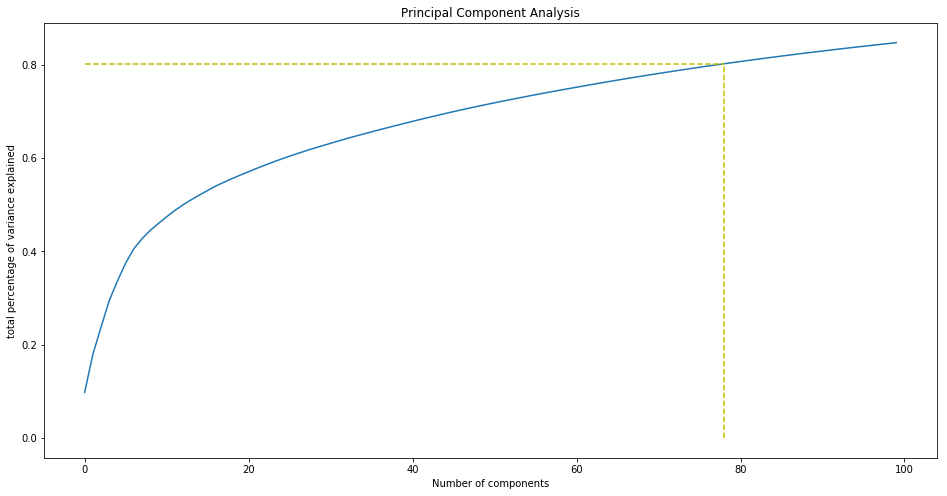

In [61]:
fig, ax = plt.subplots(figsize=(16,8))

explained_var_r_all = np.cumsum(pca_population.explained_variance_ratio_)

ax.plot(explained_var_r_all)

ax.set_title("Principal Component Analysis")
ax.set_xlabel("Number of components")
ax.set_ylabel('total percentage of variance explained')

# the first 79 [0-78] components can give more than 80%: 0.80200387300360398
# np.where(explained_var_r_all > 0.80)
# explained_var_r_all[78]

index = 78
ax.plot(np.arange(index+1), np.ones(index+1) * explained_var_r_all[index], "--y")

ax.plot(np.ones(10)*index, np.linspace(0, explained_var_r_all[index], 10), "--y")

In [46]:
azdias_pca = pca_population.transform(azdias_scaled)
customers_pca = pca_population.transform(customers_scaled)

print(azdias_pca.shape)
print(customers_pca.shape)

(798057, 100)
(141723, 100)


In [48]:
azdias_pca = pd.DataFrame(azdias_pca)
customers_pca = pd.DataFrame(customers_pca)

**use the first two principal components, check the data distribution**

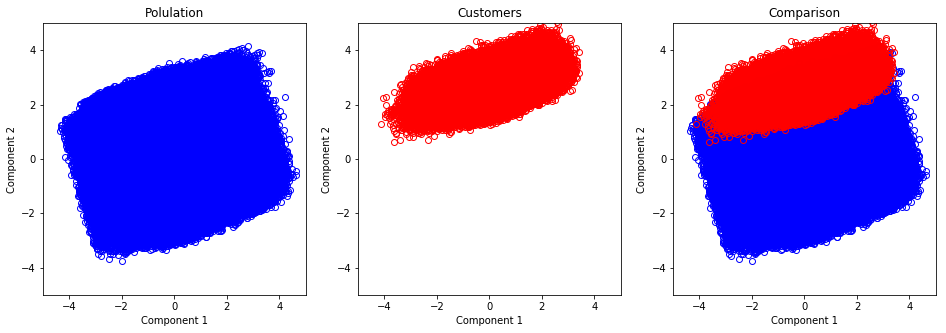

In [57]:
# use the first two columns, check the data distribution

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,5))

ax[0].plot(azdias_pca.iloc[:,0], azdias_pca.iloc[:,1], "bo", markerfacecolor='none')

ax[1].plot(customers_pca.iloc[:,0], customers_pca.iloc[:,1], "ro", markerfacecolor='none')

ax[2].plot(azdias_pca.iloc[:,0], azdias_pca.iloc[:,1], "bo", markerfacecolor='none')
ax[2].plot(customers_pca.iloc[:,0], customers_pca.iloc[:,1], "ro", markerfacecolor='none')

ax[0].set_title("Polulation")
ax[0].set_xlabel("Component 1")
ax[0].set_ylabel("Component 2")
ax[0].set_xlim(-5,5)
ax[0].set_ylim(-5,5)

ax[1].set_title("Customers")
ax[1].set_xlabel("Component 1")
ax[1].set_ylabel("Component 2")
ax[1].set_xlim(-5,5)
ax[1].set_ylim(-5,5)

ax[2].set_title("Comparison")
ax[2].set_xlabel("Component 1")
ax[2].set_ylabel("Component 2")
ax[2].set_xlim(-5,5)
ax[2].set_ylim(-5,5)

plt.savefig("A_simple_segmentation_check.pdf")

__Note:__
1. This indicates the principle components (even with only the first two compoments) can be use to seperate the customers (target) from general population;

2. With the priciple components, we can further use clustering as unsupervised method to identify the target customers

In [63]:
### only use the first 78 

azdias_pca_reduced = azdias_pca.iloc[:,0:79]
azidia_pca = None

customers_pca_reduced = customers_pca.iloc[:,0:79]
customers_pca = None

gc.collect()

9156

In [65]:
print(azdias_pca_reduced.shape)
print(customers_pca_reduced.shape)
798057 + 141723

(798057, 79)
(141723, 79)


939780

In [67]:
pd.concat([azdias_pca_reduced, customers_pca_reduced], axis=0).shape

(939780, 79)

### Use Clustering

In [71]:
#from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

batch_size = 100000
wcss = []

# use 2-10 clusters to find the Elbow
for i in np.arange(2, 20):
    
    #kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    
    # use MiniBatchKMeans for compuatational efficiency
    mbk = MiniBatchKMeans(init='k-means++', n_clusters=i, batch_size=batch_size, max_iter=300,
                  n_init=5, max_no_improvement=5, verbose=0)
    
    # fit all the data for the clustering
    mbk.fit(pd.concat([azdias_pca_reduced, customers_pca_reduced], axis=0))
    
    wcss.append(mbk.inertia_)

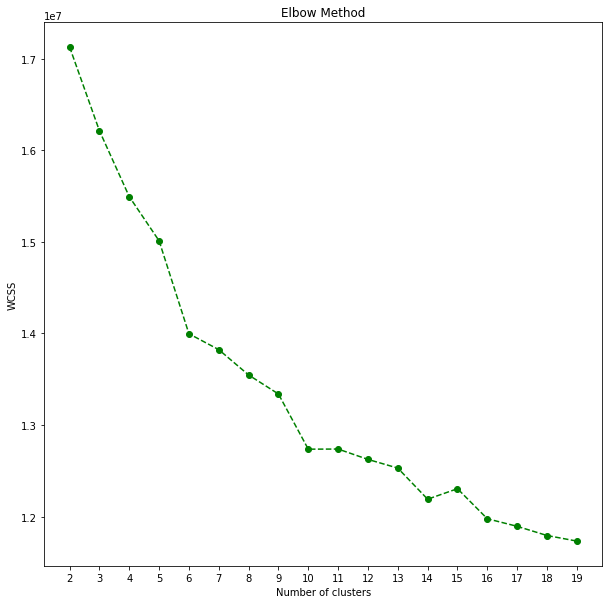

In [77]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(np.arange(2, 20), wcss, linestyle = "--", marker = "o", color = 'g')
ax.set_title('Elbow Method')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
ax.set_xticks(ticks = np.arange(2, 20).tolist())
plt.savefig("Elbow_method_clustering.pdf")

__Note:__

Since we use MiniBatchKMeans to save the computational cost, we can see the elbow curve is not very smooth. But still, we can see n_cluster = 14 may be a reasonable choice.

### Check distribution among clusters

In [78]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=14, init='k-means++', max_iter=300, n_init=10, random_state=1234)

# do the prediction on the whole dataset, population data plus customer data
clustering_results_all = kmeans.fit_predict(pd.concat([azdias_pca_reduced, customers_pca_reduced], axis=0))

In [80]:
clustering_results_all.shape

(939780,)

In [82]:
# split the prediction result for population data plus customer data

index_popul = 798057

u_1, count_popul = np.unique(clustering_results_all[0:index_popul],return_counts=True)
u_2, count_customer = np.unique(clustering_results_all[index_popul:],return_counts=True)


In [83]:
# check all the clusters

print(u_1)
print(u_2)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
[ 0  3  4  5  7  8  9 11 12]


In [86]:
# get the percentage distribution

count_popul_perc = count_popul/sum(count_popul)
count_customer_perc = count_customer/sum(count_customer)

In [92]:
count_customer_perc

array([ 0.04062149,  0.47966808,  0.00948329,  0.00953974,  0.0344757 ,
        0.0063363 ,  0.11380651,  0.03472266,  0.27134622])

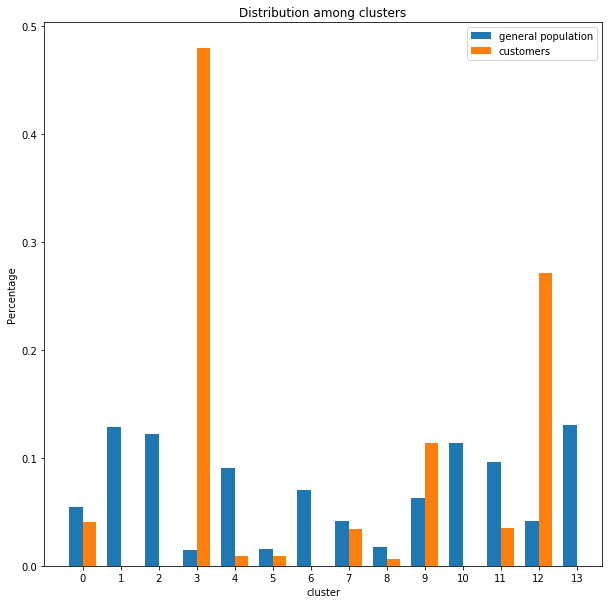

In [89]:
fig, ax = plt.subplots(figsize=(10,10))

width = 0.35

rects1 = ax.bar(u_1 - width/2, count_popul_perc, width, label='general population')
rects2 = ax.bar(u_2 + width/2, count_customer_perc, width, label='customers')

ax.set_ylabel('Percentage')
ax.set_xlabel('cluster')
ax.set_title("Distribution among clusters")
ax.set_xticks(np.arange(14))
ax.legend()

plt.savefig("distribution_among_clusters.pdf")

### Some observations and conclusions

1. We can see kmeans has a good ability to distinguish the general population and customers
2. None of the customers fall into cluster [1, 2, 6, 10, 13]
3. Customers tend to fall into cluster [3, 9, 12]. Any intances falling in these three clusters, particularly cluster 3 and 12, should be the most valuable targets for marketing

**Summary:** the impressive result of customer segmentation by Kmeans Clustering indicates that **the features from PCA** have the powers to distinguish the customer from the general population.

<a id="part-1.2"><br>
### Part 1.2: another PCA approach (named as PCA2)
    
</a></br> Go to [Table](#table)<br>

    
We see the successful application of PCA in the previous section. However, in Part 2 for the supervised problem, classifier which is built based on the features from PCA doesn't have a very satisfying performance. To address this, I improved the aforementioned PCA approch with some modifications as follows:

1. Build the PCA transformer with the data combination of mailorder customers and general population;
2. The first 150 principle components will be used, which can explain 90% of the variance, and thus should be more predictive power for the supervised problem.

In [5]:
# load the customers_clean data
customers_clean = pd.read_csv("./clean_data/customers_clean.csv")
print(customers_clean.shape)

extra_cols = ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']
customers_clean.drop(columns=extra_cols, inplace=True)
print(customers_clean.shape)


(141723, 360)
(141723, 357)


In [6]:
# scale
import pickle

# load rescaler from the picke file
with open('./clean_data/scaler.pkl', 'rb') as pickle_file:
        max_abs_scaler_customer = pickle.load(pickle_file)


customers_scale = max_abs_scaler_customer.transform(customers_clean)

In [6]:
# load azdias_scaled data first
azdias_scaled = pd.read_csv("./clean_data/azdias_scaled.csv")
print(azdias_scaled.shape)

(798057, 357)


In [10]:
seed = 1234

**downsample the population data to reduce the computational time**

In [11]:
azdias_scaled_down_sample = azdias_scaled.sample(frac=0.5,random_state=seed)

In [12]:
azdias_scaled_down_sample.shape

(399028, 357)

**Now use customer data plus population data to fit the PCA transformer and save it to pickle file**

In [13]:
from sklearn.decomposition import PCA

n_copmt = 150

pca_all = PCA(n_components=n_copmt)
pca_all.fit(np.concatenate((customers_scale, azdias_scaled_down_sample.values), axis=0))

# save pca in a pickle file
with open('./clean_data/pca_all.pkl', 'wb') as pickle_file:
        pickle.dump(pca_all, pickle_file)

In [7]:
import pickle

with open('./clean_data/pca_all.pkl', 'rb') as pickle_file:
        pca_all = pickle.load(pickle_file)

**check how many top component can give 90% variance explained**

In [8]:
explained_var_r_all = np.cumsum(pca_all.explained_variance_ratio_)

#the first 79 [0-78] components can give more than 80%: 0.80200387300360398
np.where(explained_var_r_all > 0.90)
#explained_var_r_all[78]

(array([128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149]),)

Text(0,0.5,'total percentage of variance explained')

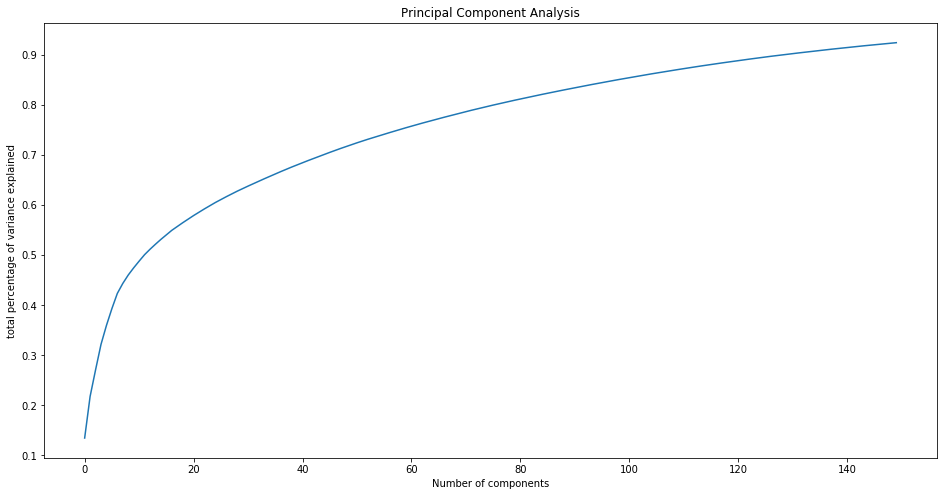

In [7]:
fig, ax = plt.subplots(figsize=(16,8))

explained_var_r_all = np.cumsum(pca_all.explained_variance_ratio_)

ax.plot(explained_var_r_all)

ax.set_title("Principal Component Analysis")
ax.set_xlabel("Number of components")
ax.set_ylabel('total percentage of variance explained')

#index = 78
#ax.plot(np.arange(index+1), np.ones(index+1) * explained_var_r_all[index], "--y")

#ax.plot(np.ones(10)*index, np.linspace(0, explained_var_r_all[index], 10), "--y")

<a id="part-2"><br>
## Part 2: Supervised Learning Model
</a></br>Go to [Table](#table)<br>
Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

<a id="part-2-step1"><br>
### Part 2.1: Load train data and do some pre-processing
</a></br>Go to [Table](#table)<br>
</a></br>Go to [Part 2.2](#part-2-step2)<br>

In [6]:
# now just import the preprocessing functions from "helper_functions/preprocessing.py"

from preprocessing import *

In [7]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(42962, 367)
----------
Row null values histogram (Row number counts V.S. Missing value percentage):



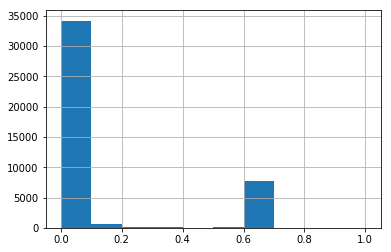

In [8]:
# a quick check on the column-wise missing value 
print(mailout_train.shape)
#print(mailout_train.isnull().sum()/mailout_train.shape[0])
miss_data_check_row(mailout_train)

In [10]:
# some basic check on the reponse variable
print(mailout_train["RESPONSE"].isnull().sum()/mailout_train.shape[0])

reponse_value, response_num = np.unique(mailout_train["RESPONSE"], return_counts=True)

print("non-response: response:", reponse_value, "\n", response_num/mailout_train.shape[0])

0.0
non-response: response: [0 1] 
 [ 0.98761696  0.01238304]


In [11]:
print("non-response: response:", reponse_value, "\n", response_num)

non-response: response: [0 1] 
 [42430   532]


#### need to repeat all the preprocessing

In [12]:
cols_to_drop = list(map(lambda x: "ALTER_KIND"+str(x), [1,2,3,4])) \
+ ["EXTSEL992", "CAMEO_DEU_2015"] \
+ ["D19_LETZTER_KAUF_BRANCHE", "EINGEFUEGT_AM", "OST_WEST_KZ"]

# apply to customers
mailout_train_clean = drop_columns(mailout_train, cols_to_drop)
mailout_train_clean = remove_row(mailout_train_clean)
mailout_train_clean = miss_data_impu(mailout_train_clean)

print(mailout_train_clean.shape)

(42962, 358)


In [13]:
# double check the types of columns before using scaling
col_types = mailout_train_clean.dtypes
col_types[col_types != float][col_types != int]

Series([], dtype: object)

**split training data into X and Y**

In [14]:
cols_X = [col for col in mailout_train_clean.columns.tolist() if col not in ["RESPONSE"]]

col_Y = ["RESPONSE"]

mailout_train_clean_X = mailout_train_clean[cols_X]
mailout_train_clean_Y = mailout_train_clean[col_Y]

<a id="part-2-PCA1"><br>
## Legacy: Supervised Learning Model with PCA 1
</a></br>
This section is the legacy when I dealt with the Supervised Learning Model using the results of PCA1. The updated work is based on PCA 2. You can just jump to the Part 2 for the work based on PCA2:

Go to [Part 2 step 2](#part-2-step2)<br>

</a></br>Go to [Table](#table)<br>

### ========PCA 1 (legacy) starts here=============

### L1. Data normalization and apply PCA 

#### Rescale: mailout_train_clean before applying PCA

In [20]:
# load the customers_clean data
customers_clean = pd.read_csv("./clean_data/customers_clean.csv")
print(customers_clean.shape)

extra_cols = ['PRODUCT_GROUP', 'ONLINE_PURCHASE', 'CUSTOMER_GROUP']
customers_clean.drop(columns=extra_cols, inplace=True)
print(customers_clean.shape)

(141723, 360)
(141723, 357)


In [21]:
mailout_train_clean_X.shape

(42962, 357)

In [22]:
# Rescale: customers_clean
# PCA: use azdias_scaled to scale data first

from sklearn import preprocessing

max_abs_scaler_customer = preprocessing.MaxAbsScaler()

# train the scaler first

max_abs_scaler_customer.fit(customers_clean)

# don't need the customers_clean data anymore
customers_clean = None

# apply
# mailout_train_X_scaled = max_abs_scaler_customer.transform(mailout_train_clean_X)

In [18]:
gc.collect()

2998

#### use PCA to reduce the dimension of training data

In [19]:
# load azdias_scaled data first
azdias_scaled = pd.read_csv("./clean_data/azdias_scaled.csv")

In [20]:
# use PCA to reduce the dimension for both training data and test data first

# Rescale: customers_clean
# PCA: use azdias_scaled to scale data first

#=========================

from sklearn.decomposition import PCA

n_copmt = 79

pca_population = PCA(n_components=n_copmt)

pca_population.fit(azdias_scaled)

azdias_scaled = None

In [23]:
# get the pca on training data
mailout_train_X_pca = pca_population.transform(mailout_train_X_scaled)
print(mailout_train_X_pca.shape)

(35185, 79)


**MaxAbsScaler and PCA transformer saved**

In [23]:
import pickle

# save rescaler in a picke file
with open('./clean_data/scaler.pkl', 'wb') as pickle_file:
        pickle.dump(max_abs_scaler_customer, pickle_file)

# save pca in a pickle file
with open('./clean_data/pca.pkl', 'wb') as pickle_file:
        pickle.dump(pca_population, pickle_file)

#### load the scaler and pca

In [80]:
import pickle

# save rescaler in a picke file
with open('./clean_data/scaler.pkl', 'rb') as pickle_file:
        max_abs_scaler_customer = pickle.load(pickle_file)

# save pca in a pickle file
with open('./clean_data/pca.pkl', 'rb') as pickle_file:
        pca_population = pickle.load(pickle_file)

In [19]:
mailout_train_X_scaled = max_abs_scaler_customer.transform(mailout_train_clean_X)
mailout_train_X_pca = pca_population.transform(mailout_train_X_scaled)

print(mailout_train_X_pca.shape)

(42962, 79)


In [20]:
mailout_train_X_pca = pd.DataFrame(mailout_train_X_pca, columns=list(map(lambda x: "pca_"+str(x), np.arange(1, 80))))

mailout_train_X_pca.head(5)

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_70,pca_71,pca_72,pca_73,pca_74,pca_75,pca_76,pca_77,pca_78,pca_79
0,-2.273074,2.570840,0.414765,-1.211226,1.587584,-1.199817,0.988786,-0.556577,-0.151852,0.382459,...,-0.116973,0.146313,-0.101442,0.123194,0.059347,0.209516,-0.416545,-0.197250,-0.142468,0.452863
1,0.953299,3.461298,1.040318,-1.315505,-0.410489,-0.007837,0.262034,-0.752622,0.015048,0.234995,...,-0.355451,-0.108226,-0.391016,-0.007399,-0.116792,0.096948,0.443084,-0.320161,-0.259759,-0.114332
2,-0.079342,3.342984,1.616593,-1.173662,0.416469,-0.449606,1.109263,0.670486,-0.269943,-0.424709,...,0.237279,0.106247,0.117278,0.166319,-0.036009,0.463575,-0.069498,0.366709,0.023879,0.155005
3,-0.347542,2.176118,1.580518,-1.269897,1.150091,-0.662118,3.000225,-0.552558,0.499512,0.826597,...,0.225568,-0.122915,0.197457,0.148177,-0.089090,-0.292214,0.047583,0.250025,0.151069,0.066548
4,-1.050399,2.731936,0.905010,-0.878472,1.114644,-0.741502,2.000695,0.618293,-0.366130,-0.997093,...,0.215990,0.060425,0.186635,0.056334,-0.234700,-0.057355,-0.003373,0.250949,-0.061570,0.022807


In [22]:
gc.collect()

7

### L2. Model training

In [31]:
# scoring function，which can be import from "helper_functions/algorithms_try.py"

from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

def get_accuracy_auc(model, X, ground_y):
    predict_y = model.predict(X)
    predict_y_proba = model.predict_proba(X)
    #
    accuracy_score = (predict_y == ground_y).sum()/len(predict_y)
    # ROC-AUC
    auc_score = roc_auc_score(ground_y, predict_y_proba[:,1])
    # PR_AUC
    pr_auc_score = average_precision_score(ground_y, predict_y_proba[:,1])
    #
    #print("accuracy score: {0:6.4f}, ROC-AUC score: {1:6.4f}, PR-AUC score: {2:6.4f}".\
    #  format(accuracy_score, auc_score, pr_auc_score))
    
    # Confusion matrix:
    #print("Confusion matrix [[TN, FP]\n[FN, TP]]:\n", confusion_matrix(ground_y, predict_y))
    
    return accuracy_score, auc_score, pr_auc_score

In [19]:
seed = 1234

#### L2.1. use Random forest first (an untune version)

In [36]:
# use Random forest first

from sklearn.ensemble import RandomForestClassifier

rdf_hyperparam = {"n_estimators": 300, "max_depth": 10, "max_features": 0.8, 
                  "class_weight": "balanced", "bootstrap": True, "oob_score": True, 
                  "n_jobs": -1, "random_state": seed}

rdf_clf = RandomForestClassifier(**rdf_hyperparam)

rdf_clf.fit(X=mailout_train_X_pca, y = mailout_train_clean_Y)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=10, max_features=0.8,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=True, random_state=1234,
            verbose=0, warm_start=False)

In [84]:
with open("./clean_data/models/random_forest.pkl", 'wb') as pickle_file:
    pickle.dump(rdf_clf, pickle_file)

#### * get the feature importance (legacy)

In [ ]:
## get the feature importance
rdf_feature_import = pd.DataFrame(list(map(lambda x: "pca_"+str(x), np.arange(1, 80))), columns=["pca_feature"])

rdf_feature_import["feature_imp"] = rdf_clf.feature_importances_


In [42]:
rdf_feature_import.sort_values(by="feature_imp", ascending=False)

,pca_feature,feature_imp
18,pca_19,0.035175
27,pca_28,0.027482
31,pca_32,0.026139
8,pca_9,0.018916
49,pca_50,0.018897
66,pca_67,0.018397
33,pca_34,0.018313
22,pca_23,0.018165
58,pca_59,0.016732
72,pca_73,0.016645


#### L2.2. ===== Random forest, using cv for tuning (legacy)========

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier

skf = StratifiedKFold(n_splits=3)

rdf = RandomForestClassifier(n_estimators=200,
                             min_impurity_decrease=0.001, 
                             class_weight= "balanced",
                             n_jobs=-1)



rdf_hyperparam = {"max_depth": [6,8,10], "max_features": [0.8,1]}

rdf_clf_1 = GridSearchCV(estimator=rdf, param_grid=rdf_hyperparam, 
                         cv=skf, scoring='roc_auc',refit=True)

rdf_clf_1.fit(X=mailout_train_X_pca, y = mailout_train_clean_Y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:458: DataConversionWarning: A column-vector y was passed when a 

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.001,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [6, 8, 10], 'max_features': [0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [38]:
rdf_clf_1.best_params_

{'max_depth': 10, 'max_features': 0.8}

In [40]:
# the result just looks bad. Perhaps we loose too much useful information

print(rdf_clf_1.cv_results_['params'])
print(rdf_clf_1.cv_results_["mean_train_score"])
print(rdf_clf_1.cv_results_["mean_test_score"])

[{'max_depth': 6, 'max_features': 0.8}, {'max_depth': 6, 'max_features': 1}, {'max_depth': 8, 'max_features': 0.8}, {'max_depth': 8, 'max_features': 1}, {'max_depth': 10, 'max_features': 0.8}, {'max_depth': 10, 'max_features': 1}]
[ 0.97861409  0.96280349  0.99077038  0.98004925  0.99424107  0.98561331]
[ 0.59346865  0.58806634  0.59388031  0.58617959  0.59867214  0.57701432]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


In [41]:
rdf_clf_1_best = rdf_clf_1.best_estimator_

with open("./clean_data/models/random_forest_1.pkl", 'wb') as pickle_file:
    pickle.dump(rdf_clf_1_best, pickle_file)

#### ===== Random forest, using cv for tuning (legacy) END========

### ========PCA 1 (legacy) End here=============

<a id="part-2-step2"><br>
### Part 2.2: rescale and pca
</a></br>Go to [Table](#table)<br>
</a></br>Go to [part 2.1](#part-2-step1)<br>

### 2.2.1. apply the new PCA (PCA2 with 150 principla components) here

In [15]:
import pickle

# load rescaler in a picke file
with open('./clean_data/scaler.pkl', 'rb') as pickle_file:
        max_abs_scaler_customer = pickle.load(pickle_file)
        

# load pca_all
with open('./clean_data/pca_all.pkl', 'rb') as pickle_file:
        pca_all = pickle.load(pickle_file)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MaxAbsScaler from version 0.19.1 when using version 0.22.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklea

**apply the saved scaler and pca transfomer**

In [16]:
mailout_train_X_scaled = max_abs_scaler_customer.transform(mailout_train_clean_X)

mailout_train_X_pca = pca_all.transform(mailout_train_X_scaled)

mailout_train_X_pca = pd.DataFrame(mailout_train_X_pca, columns=list(map(lambda x: "pca_"+str(x), np.arange(1, 151))))

mailout_train_X_pca.head(5)

,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,...,pca_141,pca_142,pca_143,pca_144,pca_145,pca_146,pca_147,pca_148,pca_149,pca_150
0,-1.860474,-2.942631,-0.084402,-0.448251,1.159523,-0.322668,-0.522914,-0.815203,0.014560,-0.050851,...,-0.365931,0.355804,-0.325957,0.181793,0.107030,-0.012522,-0.143042,-0.034096,-0.018559,0.046150
1,-3.025092,0.196136,-0.343965,0.272909,-1.154563,0.215603,-0.179251,-0.979685,0.132264,-0.105126,...,-0.055766,0.129688,0.160888,0.077109,0.501152,-0.424989,0.018069,0.338300,-0.013672,-0.132237
2,-2.939660,-0.914823,-0.731033,0.688005,0.004460,-0.121369,0.134214,0.265413,-0.500594,0.826636,...,0.065921,-0.062578,-0.174627,0.247268,0.072720,0.128616,0.025132,0.004088,-0.125638,-0.316107
3,-2.594172,-1.178409,-1.394763,0.297748,1.734109,-0.844213,1.418758,-0.871785,0.566853,-0.984914,...,-0.133938,-0.193296,-0.044138,-0.023870,0.071799,0.018637,-0.184130,0.012785,0.140768,0.051585
4,-2.403556,-1.794464,-0.342607,0.182578,1.168364,-0.536863,0.639639,0.076737,-0.521084,1.325973,...,-0.167784,-0.045400,0.267985,-0.010301,0.006767,0.002579,0.012797,-0.045166,0.066582,0.160288


In [18]:
print(mailout_train_X_pca.shape)

# save data for further use
mailout_train_data_clean = pd.concat([mailout_train_X_pca,mailout_train_clean_Y], axis=1)
mailout_train_data_clean.to_csv("./clean_data/02_23_2020/mailout_train_data_pca_clean.csv", index=False)

(42962, 150)


**Import the helper function for scoring**

*get_accuracy_auc* will print the (accuracy, AUC-ROC score, AUC_PR score), and AUC-ROC score is the key model performance evaluation.

In [17]:
from algorithms_try import get_accuracy_auc

In [18]:
seed = 1234

**training-validation split**

In [75]:
# train-validation split

from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(mailout_train_X_pca,mailout_train_clean_Y,
                                                      test_size=0.3, stratify= mailout_train_clean_Y,
                                                      random_state=seed)

print(X_train.shape, X_valid.shape)

print(y_train.shape, y_valid.shape)

(30073, 150) (12889, 150)
(30073, 1) (12889, 1)


### 2.2.2 XGB (2020/02/23)

```Bash
pip install xgboost
# xgboost-1.0.1
```

**train with early stop**

In [21]:
import xgboost as xgb

p_n_weight = 0.98761696/0.01238304

param_dist = {'objective':'binary:logistic', 
              'n_estimators':500,
              "max_depth": 6,
              "learning_rate": 0.02,
              "subsample": 0.8,
              "colsample_bylevel": 0.8,
              "colsample_bytree": 0.8,
              "scale_pos_weight": p_n_weight,
              "min_child_weight": 200,
              "seed": seed
             }

xgb_clf = xgb.XGBClassifier(**param_dist)

xgb_clf.fit(X_train.values, y_train.values,
        eval_set=[(X_train.values, y_train.values), (X_valid.values, y_valid.values)],
        eval_metric='auc',
        early_stopping_rounds=15,
        verbose=False)

print(xgb_clf.best_score, "\n", xgb_clf.best_iteration, "\n",  xgb_clf.best_ntree_limit)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.652766 
 23 
 24


In [22]:
print(xgb_clf.get_num_boosting_rounds())

print(xgb_clf.best_score, "\n", xgb_clf.best_iteration, "\n",  xgb_clf.best_ntree_limit)


500
0.652766 
 23 
 24


**check the auc scores on training set and validation set**

In [23]:
evals_result = xgb_clf.evals_result()

# this is for training set
print(evals_result["validation_0"]["auc"])
# this is for validation set
print(evals_result["validation_1"]["auc"])

[0.69286, 0.752378, 0.792675, 0.828809, 0.84606, 0.866296, 0.874427, 0.876204, 0.888449, 0.896589, 0.901064, 0.912074, 0.918786, 0.923154, 0.922046, 0.923626, 0.924994, 0.926269, 0.928127, 0.930021, 0.930126, 0.934051, 0.936675, 0.938225, 0.939443, 0.939186, 0.941979, 0.943996, 0.945488, 0.94648, 0.947966, 0.947622, 0.950285, 0.951441, 0.951511, 0.951719, 0.953037, 0.953979]
[0.582329, 0.597785, 0.624611, 0.632885, 0.632516, 0.635113, 0.640639, 0.638747, 0.645119, 0.639513, 0.634177, 0.634376, 0.63847, 0.640789, 0.639123, 0.643704, 0.643919, 0.64322, 0.64398, 0.645829, 0.648572, 0.650212, 0.649775, 0.652766, 0.648702, 0.647686, 0.64609, 0.649807, 0.647496, 0.645038, 0.642898, 0.642555, 0.638568, 0.63933, 0.638567, 0.636759, 0.637698, 0.638506]


**refit the model with whole dataset**

In [28]:
### refit the model with whole dataset

import xgboost as xgb

p_n_weight = 0.98761696/0.01238304


param_dist = {'objective':'binary:logistic', 
              'n_estimators':24,
              "max_depth": 6,
              "learning_rate": 0.02,
              "subsample": 0.8,
              "colsample_bylevel": 0.8,
              "colsample_bytree": 0.8,
              "scale_pos_weight": p_n_weight,
              "min_child_weight": 200,
              "seed": seed
             }

xgb_clf = xgb.XGBClassifier(**param_dist)

xgb_clf.fit(mailout_train_X_pca.values, mailout_train_clean_Y.values.ravel(),
        eval_set=[(X_valid.values, y_valid.values.ravel())],
        eval_metric='auc',
        verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=200, missing=nan, monotone_constraints=None,
              n_estimators=24, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1234, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=79.75561413029433, seed=1234,
              subsample=0.8, tree_method=None, validate_parameters=False,
              verbosity=None)

In [29]:
evals_result = xgb_clf.evals_result()

evals_result

{'validation_0': {'auc': [0.683231,
   0.767335,
   0.815575,
   0.827404,
   0.827215,
   0.83666,
   0.862558,
   0.868045,
   0.881243,
   0.884128,
   0.884763,
   0.89226,
   0.896174,
   0.895392,
   0.892216,
   0.891101,
   0.895552,
   0.898838,
   0.902867,
   0.909229,
   0.913225,
   0.914905,
   0.916273,
   0.91593]}}

**save the trained xgb model**

In [30]:
with open("./clean_data/02_23_2020/models/xgb_v1.pkl", 'wb') as pickle_file:
    pickle.dump(xgb_clf, pickle_file)

**try xgboost with very small depth and also try a smaller learning rate to avoid overfitting**

Note: it turned out this didn't help, only building more trees

In [66]:
### we should try xgboost with very small depth to avoid overfitting

# ./helper_functions/algorithms_try.py
from algorithms_try import xgb_train

In [70]:
### doesn't help!
p_n_weight = 0.98761696/0.01238304

param_dist = {'objective':'binary:logistic', 
              'n_estimators':500,
              "max_depth": 2,
              "learning_rate": 0.01,
              "subsample": 1,
              "colsample_bylevel": 0.8,
              "colsample_bytree": 0.8,
              "scale_pos_weight": p_n_weight,
              "min_child_weight": 200,
              "seed": seed
             }


xgb_clf_v2 = xgb_train(X_train, y_train, 
                       X_valid, y_valid,
                       mailout_train_X_pca, mailout_train_clean_Y,
                       param_dist,early_stopping_rounds=30)

# the print information
# print(xgb_clf.best_score, "\n", xgb_clf.best_iteration, "\n",  xgb_clf.best_ntree_limit)

0.620436 
 210 
 211


### 2.2.3 XGB with calibration (2020/02/29)

Also try to calibarate the output score from XGB classfier, so the socre has a meaning of probability, but later I realized this will not improve the AUC score. You can just skip this section.
```Python
from sklearn.calibration import CalibratedClassifierCV
```

In [88]:
### refit the model with whole dataset

import xgboost as xgb

p_n_weight = 0.98761696/0.01238304


param_dist = {'objective':'binary:logistic', 
              'n_estimators':24,
              "max_depth": 6,
              "learning_rate": 0.02,
              "subsample": 0.8,
              "colsample_bylevel": 0.8,
              "colsample_bytree": 0.8,
              "scale_pos_weight": p_n_weight,
              "min_child_weight": 200,
              "seed": seed
             }

xgb_clf = xgb.XGBClassifier(**param_dist)

xgb_clf.fit(mailout_train_X_pca.values, mailout_train_clean_Y.values.ravel(),
        eval_set=[(X_valid.values, y_valid.values.ravel())],
        eval_metric='auc',
        verbose=False)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=200, missing=nan, monotone_constraints=None,
              n_estimators=24, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1234, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=79.75561413029433, seed=1234,
              subsample=0.8, tree_method=None, validate_parameters=False,
              verbosity=None)

In [89]:
score_valid = get_accuracy_auc(xgb_clf, X_valid.values, y_valid.values.ravel())

print(score_valid)

(0.82721700674994181, 0.91593015947835654, 0.14678077481649143)


In [90]:
score_whole = get_accuracy_auc(xgb_clf, mailout_train_X_pca.values, mailout_train_clean_Y.values.ravel())

print(score_whole)

(0.82270378474000283, 0.91649871349360923, 0.15721966871024276)


In [81]:
from sklearn.calibration import CalibratedClassifierCV

In [91]:
xgb_clf_sig = CalibratedClassifierCV(xgb_clf, method="sigmoid", cv="prefit")

In [92]:
xgb_clf_sig.fit(mailout_train_X_pca.values, mailout_train_clean_Y.values.ravel())

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster=None,
                                                    colsample_bylevel=0.8,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.8,
                                                    gamma=0, gpu_id=-1,
                                                    importance_type='gain',
                                                    interaction_constraints=None,
                                                    learning_rate=0.02,
                                                    max_delta_step=0,
                                                    max_depth=6,
                                                    min_child_weight=200,
                                                    missing=nan,
                                                    monotone_constrai

In [93]:
sig_clf_probs = xgb_clf_sig.predict_proba(mailout_train_X_pca.values)

sig_clf_probs[:,1]

array([ 0.00263785,  0.00030896,  0.0005089 , ...,  0.05726951,
        0.00553379,  0.00235076])

In [94]:
score_valid_sig = get_accuracy_auc(xgb_clf_sig, mailout_train_X_pca.values, mailout_train_clean_Y.values.ravel())

print(score_valid_sig)

(0.98768679297984263, 0.91649871349360923, 0.15721966871024276)


In [96]:
clf_probs = xgb_clf.predict_proba(mailout_train_X_pca.values)

clf_probs[:,1]

array([ 0.46994191,  0.42946911,  0.43888113, ...,  0.52902716,
        0.48396444,  0.4677642 ], dtype=float32)

### 2.2.4. let's do another round of random forest (2020/02/23)

* check the effect of the number of trees
* note that {"max_depth": 8, "max_features": 0.8} has been tested and is a reasonable choice

In [34]:
# use Random forest
# fit the first one with 150 trees as the starting model

from sklearn.ensemble import RandomForestClassifier

rdf_hyperparam = {"max_depth": 8, "max_features": 0.8, 
                  "class_weight": "balanced",
                  "max_samples": 0.8,
                  "n_jobs": -1, "random_state": seed}

min_estimators = 150; max_estimators = 250

rdf_clf = RandomForestClassifier(**rdf_hyperparam)

all_scores = [] #(accuracy, AUC-ROC, AUC-PR) for validation set
all_scores_train = [] # #(accuracy, AUC-ROC, AUC-PR) for training set
####
rdf_clf.set_params(n_estimators=min_estimators)
rdf_clf.fit(X=X_train.values, y=y_train.values.ravel())

scores_train = get_accuracy_auc(rdf_clf, X_train.values, y_train.values.ravel())
print(scores_train)
all_scores_train.append(scores_train)

scores = get_accuracy_auc(rdf_clf, X_valid.values, y_valid.values.ravel())
print(scores)

all_scores.append(scores)  

# print information
#(accuracy, AUC-ROC, AUC-PR)

(0.9809131114288564, 0.98512671815474162, 0.33049466560304014)
(0.970672666614943, 0.62119152132924804, 0.019475448573507574)


__Additional note:__
```Python
Look like we have the overfitting issue. I played with the max_sample parameter to see if this can help. But it didn't relieve the overfitting issue
Performance on training set:
(0.97545971469424397, 0.98613683040975042, 0.35201185509738747)
Performance on validation set:
(0.96345721157576225, 0.61097174758425643, 0.019517748652442178)
```

**Loop over [151, 250] number of trees to see how the number of trees can improve the performance**

In [35]:
####
for i in range(min_estimators + 1, max_estimators + 1):
    
    rdf_clf.set_params(warm_start=True)
    rdf_clf.set_params(n_estimators=i)
    rdf_clf.fit(X=X_train.values, y=y_train.values.ravel())
    
    #
    scores = get_accuracy_auc(rdf_clf, X_valid.values, y_valid.values.ravel())
    all_scores.append(scores)
    
    scores_train = get_accuracy_auc(rdf_clf, X_train.values, y_train.values.ravel())
    all_scores_train.append(scores_train)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions. Pass the resulting weights as the class_weight parameter.
  warn('class_weight presets "balanced" or '
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_forest.py:569: UserWarning: class_weight presets "balanced" or "balanced_subsample" are not recommended for warm_start if the fitted data differs from the full dataset. In order to use "balanced" weights, use compute_class_weight ("balanced", classes, y). In place of y you can use a large enough sample of the full training set target to properly estimate the class frequency distributions.

In [36]:
all_scores = np.asarray(all_scores)

all_scores_train = np.asarray(all_scores_train)

**plot the AUC scores on training set and validation set as a function of tree number**

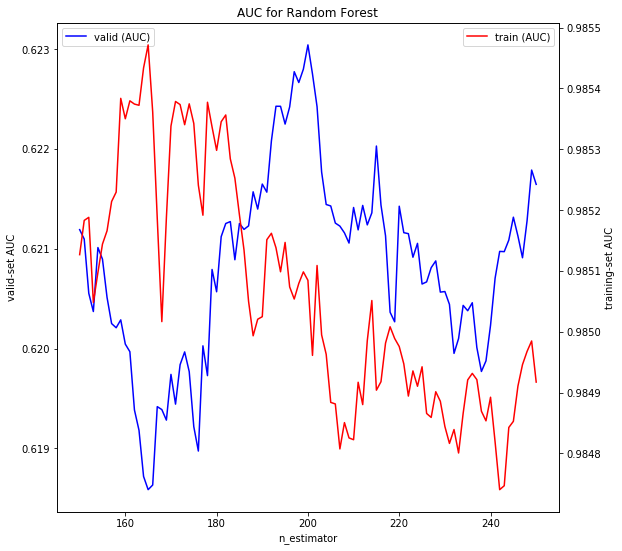

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,9))

ax.plot(np.arange(min_estimators, max_estimators + 1), all_scores[:,1], "-b", label="valid (AUC)")
ax.set_title("AUC for Random Forest")
ax.set_xlabel("n_estimator")
ax.set_ylabel("valid-set AUC")
ax.legend(loc='upper left')

ax2 = ax.twinx()
ax2.plot(np.arange(min_estimators, max_estimators + 1), all_scores_train[:,1], "-r", label="train (AUC)")
ax2.set_ylabel("training-set AUC")
ax2.legend(loc='upper right')

In [49]:
best_tree_number = np.argmax(all_scores[:,1]) + min_estimators
print(best_tree_number)

200


### 2.2.5 use logistic regression (2020/02/23)

In [51]:
### use logistic regression, LASSO
from sklearn.model_selection import ParameterGrid

**Tune the penalty and regularization strength coarsely**

In [35]:
from sklearn.linear_model import LogisticRegression

all_scores_train = []
all_scores = []

lg_hyperparam = {"penalty": ["l1", 'l2'], "C": [1, 10, 50], 
                 "tol": [0.001], "max_iter": [200],
                 "class_weight": ["balanced"]}

for hyperparam in list(ParameterGrid(lg_hyperparam)):
    lg_clf = LogisticRegression(**hyperparam, random_state = seed)
    lg_clf.fit(X=X_train.values, y=y_train.values.ravel())
    
    print(lg_clf.n_iter_)
    
    scores_train = get_accuracy_auc(lg_clf, X_train.values, y_train.values.ravel())
    
    scores = get_accuracy_auc(lg_clf, X_valid.values, y_valid.values.ravel())

    all_scores_train.append(scores_train)
    all_scores.append(scores)

[92]
[6]
[100]
[6]
[115]
[6]


In [36]:
# model performance on validation set with different hyperparameters
# (Accuracy, AUC-ROC, AUC-PR)
all_scores

[(0.71161455504693927, 0.63603238667609396, 0.018804807760532963),
 (0.71138179843277216, 0.63585120590776967, 0.018802301155531977),
 (0.71122662735666076, 0.63563565480399087, 0.018785144978542306),
 (0.71122662735666076, 0.63560717652604293, 0.018783185019239448),
 (0.71130421289471646, 0.63558802733914688, 0.018781421980326979),
 (0.71130421289471646, 0.63559195537748447, 0.018782755550956376)]

In [38]:
# model performance on training set with different hyperparameters
# (Accuracy, AUC-ROC, AUC-PR)
all_scores_train

[(0.71758720446912516, 0.77000928247953726, 0.032282212601384558),
 (0.71742094237355769, 0.76996601975314538, 0.03225033591155424),
 (0.7174874472117847, 0.77001552751744717, 0.032232936159567016),
 (0.7175539520500116, 0.77001932884487079, 0.032230044564508398),
 (0.7175539520500116, 0.77001950986046253, 0.03222751302894622),
 (0.7175539520500116, 0.77002186306315312, 0.032226971611277189)]

In [39]:
list(ParameterGrid(lg_hyperparam))

[{'C': 1,
  'class_weight': 'balanced',
  'max_iter': 200,
  'penalty': 'l1',
  'tol': 0.001},
 {'C': 1,
  'class_weight': 'balanced',
  'max_iter': 200,
  'penalty': 'l2',
  'tol': 0.001},
 {'C': 10,
  'class_weight': 'balanced',
  'max_iter': 200,
  'penalty': 'l1',
  'tol': 0.001},
 {'C': 10,
  'class_weight': 'balanced',
  'max_iter': 200,
  'penalty': 'l2',
  'tol': 0.001},
 {'C': 50,
  'class_weight': 'balanced',
  'max_iter': 200,
  'penalty': 'l1',
  'tol': 0.001},
 {'C': 50,
  'class_weight': 'balanced',
  'max_iter': 200,
  'penalty': 'l2',
  'tol': 0.001}]

### ====== ###

**Now fine tune the "C" regularization strength**

In [54]:
from sklearn.linear_model import LogisticRegression

all_scores_train = []
all_scores = []

lg_hyperparam = {"penalty": ["l1", 'l2'], "C": [0.1, 0.5],
                 "solver": ["liblinear"],
                 "tol": [0.001], "max_iter": [200],
                 "class_weight": ["balanced"]}

for hyperparam in list(ParameterGrid(lg_hyperparam)):
    lg_clf = LogisticRegression(**hyperparam, random_state = seed)
    lg_clf.fit(X=X_train.values, y=y_train.values.ravel())
    
    print(lg_clf.n_iter_)
    
    scores_train = get_accuracy_auc(lg_clf, X_train.values, y_train.values.ravel())
    
    scores = get_accuracy_auc(lg_clf, X_valid.values, y_valid.values.ravel())

    all_scores_train.append(scores_train)
    all_scores.append(scores)

[35]
[6]
[122]
[6]


In [55]:
all_scores

[(0.71208006827527348, 0.63988775630450156, 0.018945214652270274),
 (0.71037318643804792, 0.63730850813103934, 0.018914408058388534),
 (0.71239041042749629, 0.63639229318878154, 0.01881896607198616),
 (0.71122662735666076, 0.63608787021761326, 0.018824691268956518)]

In [56]:
all_scores_train

[(0.71632361254281252, 0.76828538049296347, 0.032667990251133212),
 (0.71652312705749344, 0.76958353380810107, 0.032461903064753848),
 (0.71715492302064976, 0.76998783213193289, 0.032350269810889377),
 (0.71758720446912516, 0.76993787182865203, 0.032279506168562941)]

**train the lg model with whole dataset**

In [58]:
#### train the lg model with whole dataset
hyperparam_best = {"penalty": "l1", "C": 0.1, 
                   "solver": "liblinear",
                 "tol": 0.001, "max_iter": 200,
                 "class_weight": "balanced"}


lg_clf = LogisticRegression(**hyperparam_best, random_state = seed)
lg_clf.fit(X=mailout_train_X_pca.values, y=mailout_train_clean_Y.values.ravel())

print(lg_clf.n_iter_)

scores_whole = get_accuracy_auc(lg_clf, mailout_train_X_pca.values, mailout_train_clean_Y.values.ravel())


[55]


In [71]:
scores_whole

(0.69291466877705876, 0.75103797674719441, 0.029975729745582939)

In [72]:
# save the trained classifer into plickle file
with open("./clean_data/02_23_2020/models/lg_clg_v1.pkl", 'wb') as pickle_file:
    pickle.dump(lg_clf, pickle_file)

### 2.2.6 other attempts

**just for achive, didn't help**

#### 2.2.6.1 GradientBoostingClassifier

__upsample the positive instances to have a balance dataset__

In [76]:
## # "helper_functions/upsample_for_balance.py"

from upsample import upsample_for_balance

mailout_train_X_pca_up_sample, mailout_train_Y_up_sample = upsample_for_balance(mailout_train_X_pca, mailout_train_clean_Y, seed=1234)

Before upsample: negative v.s. positive
(42430, 151) (532, 151)
After upsample: negative v.s. positive
(42430, 151) (4256, 151)


**Early stopping to tune tree number**

In [106]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_hyperparam = {"n_estimators": 400, "max_depth": 4, "max_features": 0.8, 
                  "learning_rate": 0.05, "random_state": seed}

gbm_clf = GradientBoostingClassifier(**gbm_hyperparam,  validation_fraction=0.3, n_iter_no_change=10, tol=0.01,)

gbm_clf.fit(X=mailout_train_X_pca_up_sample, y=mailout_train_Y_up_sample)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features=0.8, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=10, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.01,
                           validation_fraction=0.3, verbose=0,
                           warm_start=False)

In [108]:
# check the number of trained trees
gbm_clf.n_estimators_

64

In [109]:
# check the performance, here we see the model performs very good on both the training set and validation set

scores_whole = get_accuracy_auc(gbm_clf, 
                                mailout_train_X_pca_up_sample.values, mailout_train_Y_up_sample.values.ravel())
print(scores_whole)

scores = get_accuracy_auc(gbm_clf, X_valid.values, y_valid.values.ravel())
print(scores)

(0.91190078396093044, 0.89527374200142107, 0.68085814771815767)
(0.98781907052525408, 0.8847137933066227, 0.39300401808273111)


#### use whole dataset to train model

In [110]:
### use whole dataset to train model

from sklearn.ensemble import GradientBoostingClassifier

gbm_hyperparam = {"n_estimators": 400, "max_depth": 4, "max_features": 0.8, 
                  "learning_rate": 0.05, "n_estimators": 64,"random_state": seed}

gbm_clf_v2_whole = GradientBoostingClassifier(**gbm_hyperparam)

gbm_clf_v2_whole.fit(X=mailout_train_X_pca_up_sample, y=mailout_train_Y_up_sample)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=4,
                           max_features=0.8, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=64,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1234, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [117]:
# check the new-fitted gbm on the whole dataset

scores_whole = get_accuracy_auc(gbm_clf_v2_whole, 
                                mailout_train_X_pca_up_sample.values, mailout_train_Y_up_sample.values.ravel())
print(scores_whole)

(0.91082979908323691, 0.90356667726941675, 0.71980952996360581)


In [119]:
# dump the model
with open("./clean_data/02_23_2020/models/gbm_v2_whole.pkl", 'wb') as pickle_file:
    pickle.dump(gbm_clf_v2_whole, pickle_file)

### =====

#### 2.2.6.2 try the NB ()

__upsample the positive instances to have a balance dataset__

In [20]:
# "helper_functions/upsample_for_balance.py"

from upsample import upsample_for_balance

mailout_train_X_pca_up_sample, mailout_train_Y_up_sample = upsample_for_balance(mailout_train_X_pca, mailout_train_clean_Y, seed=1234)

Before upsample: negative v.s. positive
(42430, 151) (532, 151)
After upsample: negative v.s. positive
(42430, 151) (4256, 151)


In [21]:
from sklearn.naive_bayes import GaussianNB

In [23]:
# Gaussian Naive Bayes

NB_clf_v2 = GaussianNB()
NB_clf_v2.fit(mailout_train_X_pca_up_sample.values, mailout_train_Y_up_sample.values.ravel())

GaussianNB(priors=None, var_smoothing=1e-09)

In [24]:
scores_train = get_accuracy_auc(NB_clf_v2, mailout_train_X_pca_up_sample.values, mailout_train_Y_up_sample.values.ravel())
print(scores_train)

(0.87681531936769053, 0.69194691965005606, 0.206352125232731)


#### 2.2.6.3 More...

Some other ensemble techniques such as simple average/min/max have also been tried, but didn't help. It turned out the logistic regression is always the superior one.

<a id="part-3"><br>
## Part 3: Kaggle Competition
</a></br>
Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [25]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 3.1. some basic information check on the test set

In [26]:
mailout_test.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


----------
Row null values histogram (Row number counts V.S. Missing value percentage):



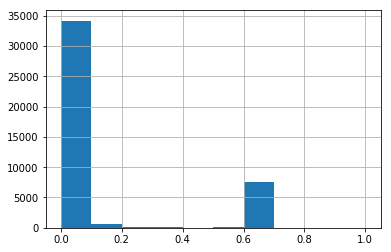

In [27]:
miss_data_check_row(mailout_test)

In [31]:
# informaiton of missing columns
mail_out_null_info = mailout_test.isnull().sum()/mailout_test.shape[0]
mail_out_null_info.sort_values(ascending=False)

ALTER_KIND4                  0.999089
ALTER_KIND3                  0.995307
ALTER_KIND2                  0.982210
ALTER_KIND1                  0.953004
KK_KUNDENTYP                 0.584479
EXTSEL992                    0.369085
HH_DELTA_FLAG                0.224570
W_KEIT_KIND_HH               0.224570
KBA05_MAXVORB                0.199309
KBA05_MOTOR                  0.199309
KBA05_MOD4                   0.199309
KBA05_MOD3                   0.199309
KBA05_MOD2                   0.199309
KBA05_MOD1                   0.199309
KBA05_MAXSEG                 0.199309
KBA05_KRSZUL                 0.199309
KBA05_MOTRAD                 0.199309
KBA05_MAXBJ                  0.199309
KBA05_MAXAH                  0.199309
KBA05_KW3                    0.199309
KBA05_KW2                    0.199309
MOBI_REGIO                   0.199309
KBA05_KW1                    0.199309
KBA05_MAXHERST               0.199309
KBA05_ZUL3                   0.199309
KBA05_SEG1                   0.199309
KBA05_KRSOBE

### 3.2 Apply the same pre-processing to test set

You can either tun the code in the following cell, or call the function transform_test_data(mailout_test, max_abs_scaler_customer, pca_all)

```Python
    from helper_functions.predict_test import transform_test_data
```

In [30]:
# same preprocess

# 1. ===============
cols_to_drop = list(map(lambda x: "ALTER_KIND"+str(x), [1,2,3,4])) \
+ ["EXTSEL992", "CAMEO_DEU_2015"] \
+ ["D19_LETZTER_KAUF_BRANCHE", "EINGEFUEGT_AM", "OST_WEST_KZ"]

mailout_test_clean = drop_columns(mailout_test, cols_to_drop)
#mailout_test_clean = remove_row(mailout_test_clean)
mailout_test_clean = miss_data_impu(mailout_test_clean)

print(mailout_test_clean.shape)

cols_X = [col for col in mailout_test_clean.columns.tolist()]

mailout_test_clean_X = mailout_test_clean[cols_X]

print(mailout_test_clean_X.shape)

# 2. ===============
# rescale
mailout_test_X_scaled = max_abs_scaler_customer.transform(mailout_test_clean_X)
# 3. ===============
# PCA
# mailout_test_X_pca = pca_population.transform(mailout_test_X_scaled)

mailout_test_X_pca = pca_all.transform(mailout_test_X_scaled)

(42833, 357)
(42833, 357)


In [31]:
# check if the shape is corret
print(mailout_test_X_pca.shape)

(42833, 150)


#### =========

### 3.3 Use the model to do the prediction

**Note:** 
1. For the sake of conciseness, I just gave the example for the logistic regression classifier
2. To avoid the repetition of same code, I also created a function to do the prediction on the test set, only work for classifers that have the sklearn API clf.predict_proba

### logistic regression (PCA2)

Usually you should have the trained classifer saved, for example, as pickle file, and just load the classifier first

In [28]:
### first create the dataframe to hold the prediction results
testset_prediction = mailout_test[["LNR"]].copy()

In [52]:
# do the prediction by calling the API predict_proba

predict_y_proba_test = lg_clf.predict_proba(mailout_test_X_pca)

# only save the probabilty of being predicted as positive (1)
testset_prediction["RESPONSE"] = predict_y_proba_test[:,1]
# save the prediction results
testset_prediction.to_csv("./clean_data/models/lg_clf_v1.csv", index=False)

__Or use the handy funciton to do the prediction__

In [38]:
# "./helper_functions/predict_test.py"

from predict_test import predict_test


predict_test(lg_clf_clf, mailout_test_X_pca, testset_prediction, predict_result_file="./clean_data/models/lg_clf_v1.csv")

### go to the Kaggle website and submit the csv file

## =======Notebook END=============